# **Machine Learning II: Deep learning classifiers for urban sound data**
<img src="https://github.com/alfredofdlv/MCII-Project/blob/main_alfredo/images/portrait.png?raw=1" alt="Portrait" style="width:100%; height:auto;">

===================================================================================================================


## **Introduction**
Urban sound recognition is a crucial component in the development of intelligent systems for cities, supporting applications in public safety, environmental monitoring, and transportation. This project focuses on designing and evaluating deep learning classifiers for recognizing urban sounds using the UrbanSound8K dataset. This dataset contains audio samples across 10 classes commonly found in urban environments, such as "siren," "dog bark," and "street music." To address the classification challenge, we implement two neural network architectures: a **Recurrent Neural Network (RNN)**, which leverages temporal patterns in audio data, and a **Convolutional Neural Network (CNN)**, which captures spatial features within spectrogram representations of audio. By comparing these models, we aim to identify which architecture is more effective in urban sound classification tasks, balancing accuracy, computational efficiency, and model complexity.


### **Abstract**

This project presents a deep learning approach for urban sound classification, utilizing the UrbanSound8K dataset to train and evaluate two neural network models: a Recurrent Neural Network (RNN) and a **Convolutional Neural Network (CNN)**. Our data preparation pipeline applies comprehensive preprocessing steps, including signal normalization and feature extraction, to transform raw audio signals into structured representations suitable for deep learning input. Model architectures are iteratively optimized through careful adjustment of layer configurations, activation functions, and hyperparameters to enhance performance.
Training strategies incorporate fine-tuning of optimizers, regularization techniques, and a robust 10-fold cross-validation approach to ensure reliable generalization and mitigate overfitting. Model performance is evaluated using classification accuracy and a cumulative confusion matrix across folds, providing insight into each model’s ability to handle distinct sound classes.

Training strategies included fine-tuning of optimizers and regularization techniques, alongside a robust **10-fold cross-validation** to assess generalization. Classification performance is evaluated based on accuracy and the confusion matrix across folds, providing insights into each model's strengths in handling distinct sound classes.

### **Objective of the work**
The primary objective of this project is to develop and assess the efficacy of two distinct neural network architectures—RNN and CNN—for urban sound classification. By conducting a comparative analysis, we aim to provide understanding of each model's performance, identifying the trade-offs in accuracy, computational demands, and architectural complexity.

### **Structure of the work**
The project is structured into the following sections:

1. **Data Preparation**: This section outlines the steps taken to preprocess the UrbanSound8K dataset. It includes methods for converting audio data into suitable features for the RNN and CNN models, specifically focusing on Mel-Frequency Cepstral Coefficients (MFCCs) for the RNN, which capture temporal patterns, and spectrograms for the CNN, which enable spatial feature extraction.
2. **Model Architectures**: A detailed description of the RNN and CNN models.
    - *RNN Architecture*: Explores the sequential processing layers of the RNN and includes comparisons of different submodels like LSTM and GRU, which capture temporal dependencies in audio features.
    - *CNN Architecture*: Describes the structure of the CNN model, emphasizing its ability to perform spatial feature extraction from spectrograms
3. **Training Strategies**: This section discusses the training approaches used for both models, including optimizers, regularization techniques, and adjustments for each model architecture.
4. **Evaluation Metrics**:  A description of the metrics used to evaluate model performance, including accuracy and confusion matrices.
5. **Deep Fool Strategy**: This section describes the use of the DeepFool algorithm to evaluate the robustness of the trained models against adversarial perturbations.
6. **Results and Discussion**: A presentation of the results obtained from the models, including accuracy and confusion matrix insights for each sound class, comparing the effectiveness of the RNN and CNN architectures.

## **Data Preparation**

In [11]:
######## LIBRARIES ###############
import soundata
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from importlib import reload
import utils
import pickle
import random
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import seaborn

### **Importing the data**

The UrbanSound8K Dataset contains 8,732 labeled sound clips (≤4 seconds each) spanning 10 urban sound classes: air conditioner, car horn, children playing, dog bark, drilling, engine idling, gun shot, jackhammer, siren, and street music. These classes represent a taxonomy of urban sounds, and each audio file is derived from field recordings uploaded to Freesound.org. Files are organized into ten predefined folds (fold1-fold10) for reproducibility and comparability of classification results.

Via the `soundata` library, in addition to the audio files in WAV format, a CSV metadata file, *UrbanSound8k.csv*, is provided. Key metadata includes:

- slice_file_name: Audio filename
- fsID: Original Freesound ID.
- start and end: Time range of the slice within the original recording.
- salience: Subjective salience rating (1 = foreground, 2 = background).
- fold: Predefined fold assignment (1-10).
- classID: Numeric class identifier (0-9).
- class: Name of the sound class.

We will also perform EDA and data visualizations.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = r'D:\data\ml2'
dataset = soundata.initialize('urbansound8k', data_home = DATA_DIR)

metadata = pd.read_csv(os.path.join(DATA_DIR,"metadata","UrbanSound8k.csv"))
print(metadata.head(4))

# Display basic information
print("Dataset Info:")
metadata.info()
# Check for missing values
print("\nChecking for missing values:")
print(metadata.isnull().sum())


      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID         

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\user\AppData\Local\Temp\ipykernel_11552\2494736104.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='fold', palette='viridis')
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\user\AppData\Local\Temp\ipykernel_11552\2494736104.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='class', order=data['cla

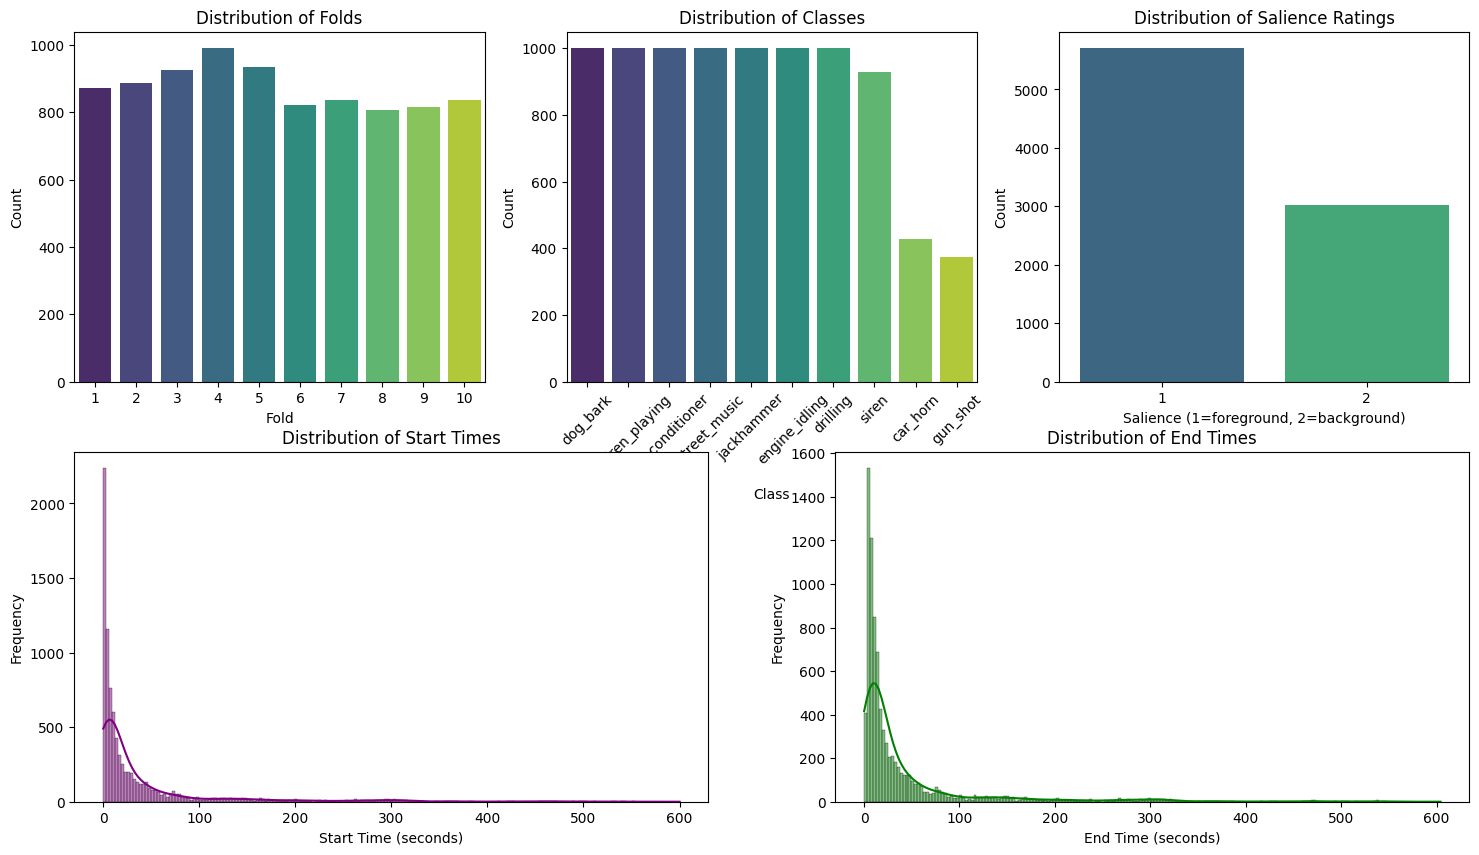

In [4]:
data = metadata


# Create a figure with a grid of subplots
plt.figure(figsize=(18, 10))

# Plot 1: Distribution of Folds
plt.subplot(2, 3, 1)
sns.countplot(data=data, x='fold', palette='viridis')
plt.title("Distribution of Folds")
plt.xlabel("Fold")
plt.ylabel("Count")

# Plot 2: Distribution of Classes
plt.subplot(2, 3, 2)
sns.countplot(data=data, x='class', order=data['class'].value_counts().index, palette='viridis')
plt.xticks(rotation=45)
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Count")

# Plot 3: Distribution of Salience Ratings
plt.subplot(2, 3, 3)
sns.countplot(data=data, x='salience', palette='viridis')
plt.title("Distribution of Salience Ratings")
plt.xlabel("Salience (1=foreground, 2=background)")
plt.ylabel("Count")

# Plot 4: Histogram of Start Times
plt.subplot(2, 2, 3)  # Adjusted for 2x2 grid starting from position 3
sns.histplot(data['start'], kde=True, color='purple')
plt.title("Distribution of Start Times")
plt.xlabel("Start Time (seconds)")
plt.ylabel("Frequency")

# Plot 5: Histogram of End Times
plt.subplot(2, 2, 4)  # Position adjusted for the last plot
sns.histplot(data['end'], kde=True, color='green')
plt.title("Distribution of End Times")
plt.xlabel("End Time (seconds)")
plt.ylabel("Frequency")

# Adjust layout to prevent overlap and add space between rows
plt.tight_layout()

plt.show()


![EDA](images/EDA1.png)

In the dataset, as observed from the plots and summary statistics above, there are no missing data values. Additionally, the distribution of samples across the folds is relatively uniform, which supports balanced cross-validation. However, we do observe a class imbalance, particularly in the underrepresentation of the *car horn* and *gunshot* classes. Furthermore, a substantial portion of the data is labeled as foreground sounds, indicating that most audio samples have been annotated as prominent in the scene.

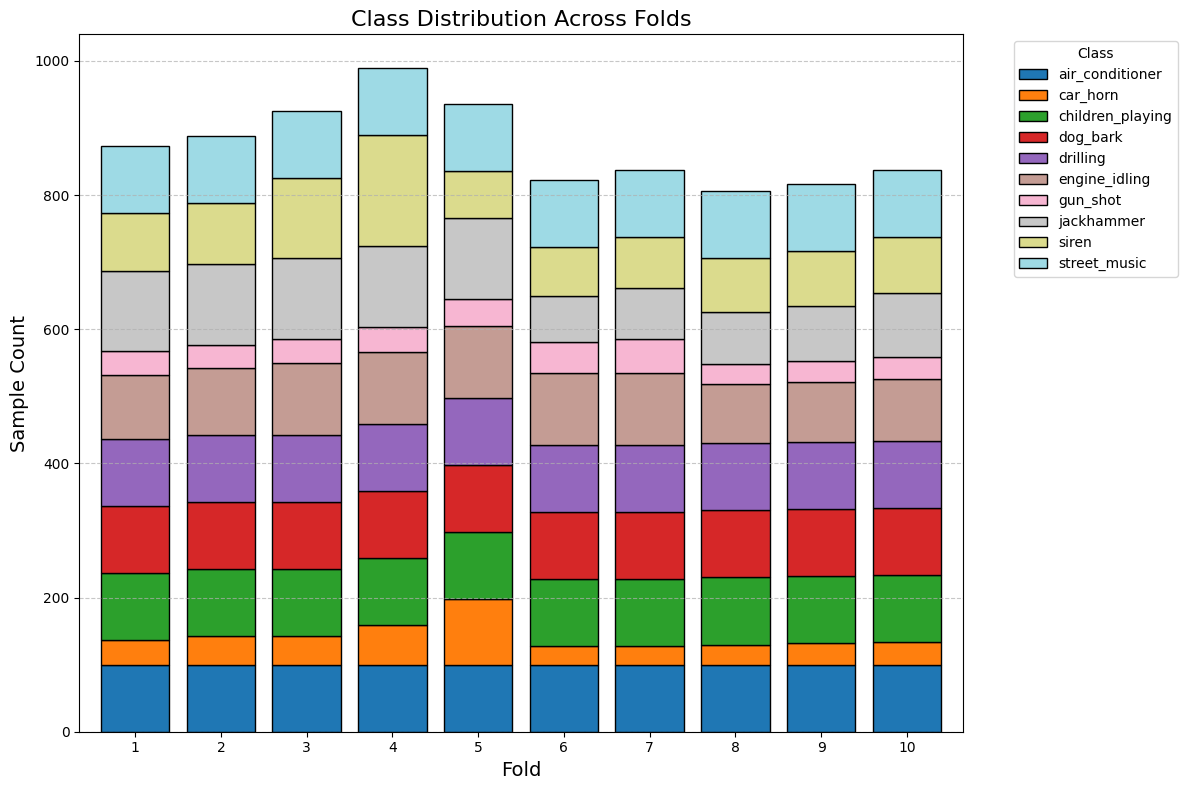

In [5]:

# Agrupar datos por 'fold' y 'class' para contar el número de muestras
fold_class_counts = data.groupby(['fold', 'class']).size().unstack(fill_value=0)

# Configuración del gráfico de barras apiladas
plt.figure(figsize=(12, 8))
fold_class_counts.plot(
    kind='bar', 
    stacked=True, 
    colormap='tab20', 
    width=0.8, 
    edgecolor='black',
    ax=plt.gca()
)

# Añadir título y etiquetas a los ejes
plt.title("Class Distribution Across Folds", fontsize=16)
plt.xlabel("Fold", fontsize=14)
plt.ylabel("Sample Count", fontsize=14)

# Añadir leyenda para identificar las clases
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

![classdistracrossfold](images/class_distr_accross_folds.png)

To evaluate whether the classes are similarly distributed across folds, we can perform a hypothesis test of independence. This test will determine if there is a significant association between the variables fold and class, indicating whether the class distributions vary across folds. Chi-square test of independence :

- ($H_o$): The class distribution is the same across all folds (i.e., there is no association between fold and class).
- ($H_1$): The class distribution is not the same across folds (there is an association between fold and class).

In [6]:
import scipy.stats as stats

contingency_table = pd.crosstab(data['fold'], data['class'])
# Perform the Chi-square test of independence
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print("Chi-square:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p)
# Interpret the result
alpha = 0.05
if p < alpha:
    print("We reject the null hypothesis: the class distribution differs across folds.")
else:
    print("We do not reject the null hypothesis: there is no significant evidence that the class distribution differs across folds.")

Chi-square: 192.2425218659076
Degrees of freedom: 81
P-value: 4.920225559810079e-11
We reject the null hypothesis: the class distribution differs across folds.


Since the p-value is extremely small, we have strong evidence to **reject the null hypothesis**. This means that the class distribution is not uniform across the folds. In other words, some folds may have an overrepresentation or underrepresentation of certain classes, which could affect the fairness of model evaluation.This class imbalance across folds can lead to skewed performance metrics, where certain folds may have an overrepresentation or underrepresentation of particular classes, impacting the model's ability to generalize effectively, as mentioned in the original paper of *Justin Salomon*.

### **Feature Extraction**

For our work with deep learning models, extracting relevant audio features is essential to ensure that the model receives inputs that can be effectively processed. Using `librosa`, a specialized library for audio analysis, we extract the following audio features:

- **Waveform**: The waveform is a simple representation of sound that captures the amplitude of an audio signal over time. While basic, it provides essential insight into the raw dynamics of the audio signal.

- **Zero Crossing Rate (ZCR)**: The Zero Crossing Rate measures how frequently the audio signal crosses the zero axis within a specified period. This feature is useful for detecting sudden changes in the signal's spectral characteristics, helping neural networks recognize phase shifts in the audio and facilitating more accurate pattern recognition.

- **Root Mean Square Energy (RMSE)**: RMSE calculates the quadratic mean of the energy in each frame of the audio signal. It is particularly useful for understanding variations in volume and intensity over time.

- **Mel-Frequency Cepstral Coefficients (MFCCs)**: MFCCs are derived from the spectrogram and are designed to model the human auditory system. These coefficients compress the audio data while preserving its most perceptually significant features, making them especially useful for tasks like speech and sound classification.

- **Spectral Centroid**: The spectral centroid represents the weighted average of the frequencies in the spectrum of an audio signal. It indicates where the majority of the spectral energy is concentrated, which correlates with the perceived brightness of the sound.

- **Spectral Bandwidth**: This feature measures the width of the frequency spectrum around the spectral centroid. It is helpful for distinguishing between complex sounds, such as noise, and more tonal sounds with a clear harmonic structure.

- **Spectral Rolloff**: Spectral rolloff marks the frequency below which a specified portion of the total spectral energy (typically 85%) is contained. This feature is valuable for distinguishing between sharp, sudden sounds and steady, continuous ones, aiding in the classification of different types of audio events.

- **Spectrogram**: A spectrogram is a visual representation that shows how the frequency components of an audio signal evolve over time. It displays changes in the frequency structure, making it an important tool for analyzing the temporal dynamics of sound.




In [8]:
from utils import create_folds
import pandas as pd 

df = pd.read_csv(r'D:\data\ml2\metadata\UrbanSound8k.csv')
directory_audio =r'D:\data\ml2\audio'
x_folds, y_folds = create_folds(directory_audio, df)


c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\Machine Learning II\Proyecto_Sonidos\.venv\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\Machine Learning II\Proyecto_Sonidos\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\Machine Learning II\Proyecto_Sonidos\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\Machine Learning II\Proyecto_Sonidos\.venv\Lib\site-pa

In [12]:
def cargar_datos_con_scaling(trFolds, testFolds, x_folds, y_folds):
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    # Combinar datos de entrenamiento
    for fold in trFolds:
        X_train.extend(x_folds[fold - 1])
        Y_train.extend(y_folds[fold - 1])

    # Combinar datos de prueba
    for fold in testFolds:
        X_test.extend(x_folds[fold - 1])
        Y_test.extend(y_folds[fold - 1])

    # Concatenar todas las características de entrenamiento para ajustar el escalador
    train_features_com = np.vstack(X_train)

    # Ajustar el escalador
    scaler = StandardScaler()
    scaler.fit(train_features_com)

    # Transformar las características de entrenamiento y prueba
    X_train = [scaler.transform(features) for features in X_train]
    X_test = [scaler.transform(features) for features in X_test]

    return X_train, Y_train, X_test, Y_test

In [19]:
from utils import  generate_train_set
import numpy as np

trFolds, testFolds = generate_train_set(train = 8)
X_train2, y_train2, X_test2, y_test2 = cargar_datos_con_scaling(trFolds, testFolds, x_folds, y_folds)

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Determinar la longitud máxima de las secuencias
max_length = max([x.shape[0] for x in X_train2 + X_test2])

# Aplicar padding a las secuencias de entrenamiento y prueba
X_train2_padded = pad_sequences(X_train2, maxlen=max_length, dtype='float32', padding='post', truncating='post')
X_test2_padded = pad_sequences(X_test2, maxlen=max_length, dtype='float32', padding='post', truncating='post')



![audio_repre](images/audios_representations.png)

After the feature extraction, we sample randomly which folds will be for train and test. And finally we will create the dataset, splitted by train, test and features and labels. We will save the dataset in a pickle file facilitating importing the data.

In [ ]:
# Cargar los datos preprocesados desde el archivo


import pickle 
with open(r"C:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\Machine Learning II\Proyecto_Sonidos\data.pkl", "rb") as f:
    new_data = pickle.load(f)

X_train2 = new_data["X_train"]
X_test2 = new_data["X_test"]
y_train2 = new_data["y_train"]
y_test2 = new_data["y_test"]

display([X_train2.shape,X_test2.shape,y_train2.shape,y_test2.shape])

In [ ]:
# Cargar los datos preprocesados desde el archivo

directory_data=r'C:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\Machine Learning II\Proyecto_Sonidos\preprocessed_data.pkl'
with open(directory_data, "rb") as f:
    new_data = pickle.load(f)

X_train = new_data["X_train"]
X_test = new_data["X_test"]
y_train = new_data["y_train"]
y_test = new_data["y_test"]

display([X_train.shape,X_test.shape,y_train.shape,y_test.shape])

# **Model Architectures**
## Recurrent Neural Networks

****Recurrent Neural Networks (RNNs)**** is a type of neural network architecture designed to model sequential data, with the use of feedback loops it allows information to persist across time steps, helping retaining information about past dependencies. In traditional neural networks, th input and output layers were connected in a feed-forward manner, meaning information flew one way, from input to output, with no feedback.

In RNNs this is not the case, as it incorporates ****cyclic connections**** that enables continuous information flow throughout each step of the sequence. This structure allows the RNNs to capture and model temporal and contextual relationships over time effectively.



In [4]:
sequence_lengths = [len(seq) for seq in X_train]
print(np.mean(sequence_lengths))
# Graficar la distribución de longitudes de las secuencias
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuction of the length of the frequencies in X_train')
plt.xlabel('Length')
plt.ylabel('Number')
plt.show()


555.0


NameError: name 'plt' is not defined

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
######### para antes

# # Crear el codificador de etiquetas
# label_encoder = LabelEncoder()

# # Ajustar y transformar las etiquetas de entrenamiento
# y_train_numeric = label_encoder.fit_transform(y_train2)

# # Transformar las etiquetas de prueba usando el mismo codificador
# y_test_numeric = label_encoder.transform(y_test2)


# num_classes = len(np.unique(y_train2))

# # Convertir etiquetas de y_train y y_test a one-hot encoding
# y_train = to_categorical(y_train_numeric, num_classes=num_classes)
# y_test = to_categorical(y_test_numeric, num_classes=num_classes)





(6936, 174, 127)
Forma de X_train después de padding: (6936, 174, 127)
Forma de X_test después de padding: (1796, 174, 127)


In [15]:
!pip3 install torch torchvision torchaudio


  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 1.8/203.1 MB 11.2 MB/s eta 0:00:19
    --------------------------------------- 4.5/203.1 MB 12.2 MB/s eta 0:00:17
   - -------------------------------------- 7.1/203.1 MB 12.5 MB/s eta 0:00:16
   - -------------------------------------- 10.0/203.1 MB 13.2 MB/s eta 0:00:15
   -- ------------------------------------- 12.8/203.1 MB 13.0 MB/s eta 0:00:15
   --- ------------------------------------ 15.5/203.1 MB 13.0 MB/s eta 0:00:15
   --- ------------------------------------ 18.1/203.1 MB 13.1 MB/s eta 0:00:15
   ---- ----------------------------------- 21.0/203.1 MB 13.2 MB/s eta 0:00:14
   ---- ----------------------------------- 23.3/203.1 MB 13.0 MB/s eta 0:00:14
   ----- ---------------------------------- 26.2/203.1 MB 12.9 MB/s eta 0:00:14
   ----- ---------------------------------- 28.6/203.1 MB 12.8 MB/s e

In [24]:
########################### NUVEVO ENTRENO #############################
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
from models import ComplexGRUModel, ComplexLSTMModel
from visualizations import plot_DL_results
import visualizations
reload(visualizations)

# Verificar si hay GPUs disponibles
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(f"Entrenando en GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No hay GPUs disponibles. El entrenamiento se realizará en la CPU.")

# Añadir una dimensión adicional para que los datos tengan forma (batch_size, sequence_length, input_dim)
X_train_padded2 = X_train2_padded
X_test_padded2 = X_test2_padded
input_dim = X_train_padded2.shape[2]  # Obtiene feature_dim de tus datos

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_numeric = label_encoder.fit_transform(y_train2)
y_test_numeric = label_encoder.transform(y_test2)

# Convertir etiquetas a tensores LongTensor
y_train_tensor = torch.tensor(y_train_numeric, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test_numeric, dtype=torch.long).to(device)

# Crear datasets
train_data = TensorDataset(torch.tensor(X_train_padded2, dtype=torch.float32).to(device), y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)

test_data = TensorDataset(torch.tensor(X_test_padded2, dtype=torch.float32).to(device), y_test_tensor)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

num_classes = len(np.unique(y_train_numeric))


# Inicialización del modelo GRU
model = ComplexGRUModel(
    input_dim=input_dim,  # Usa el input_dim correcto
    hidden_dim1=64,
    hidden_dim2=32,
    hidden_dim3=16,
    output_dim=num_classes,  # Asegúrate de que output_dim coincida con el número de clases
    dropout_rate=0.01
).to(device)


# Definir el optimizador con regularización L2 (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # Ajustar weight_decay si es necesario
criterion = nn.CrossEntropyLoss()

# # Preparación de datos (convertir etiquetas y inputs en tensores)
# y_train2 = torch.tensor(y_train).argmax(dim=1).to(device)
# train_data = TensorDataset(torch.tensor(X_train_padded2, dtype=torch.float32).to(device), y_train2)
# train_loader = DataLoader(train_data, batch_size=32, shuffle = False)

# # Convertir X_test y y_test a tensores y moverlos a la GPU
# y_test2 = torch.tensor(y_test).argmax(dim=1).to(device)
# test_data = TensorDataset(torch.tensor(X_test_padded2, dtype=torch.float32).to(device), y_test2)
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Preparar etiquetas




# Definición de la función de entrenamiento
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    train_losses = []
    valid_losses = []
    train_accuracies = []
    train_f1_scores = []
    train_recalls = []
    valid_accuracies = []
    valid_f1_scores = []
    valid_recalls = []

    for epoch in range(epochs):
        running_loss = 0.0
        all_labels = []
        all_preds = []

        # Entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        epoch_recall = recall_score(all_labels, all_preds, average='weighted')

        # Guardar las métricas de entrenamiento
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        train_f1_scores.append(epoch_f1)
        train_recalls.append(epoch_recall)

        # Validación
        model.eval()
        valid_loss = 0.0
        valid_labels = []
        valid_preds = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                valid_labels.extend(labels.cpu().tolist())
                valid_preds.extend(preds.cpu().tolist())

            valid_loss = valid_loss / len(test_loader)
            valid_accuracy = accuracy_score(valid_labels, valid_preds)
            valid_f1 = f1_score(valid_labels, valid_preds, average='weighted')
            valid_recall = recall_score(valid_labels, valid_preds, average='weighted')

            # Guardar las métricas de validación
            valid_losses.append(valid_loss)
            valid_accuracies.append(valid_accuracy)
            valid_f1_scores.append(valid_f1)
            valid_recalls.append(valid_recall)

        model.train()  # Volver al modo entrenamiento

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Train Accuracy: {epoch_accuracy:.4f} - Train F1: {epoch_f1:.4f} - Train Recall: {epoch_recall:.4f} - Valid Loss: {valid_loss:.4f} - Valid Acc: {valid_accuracy:.4f}")

    return (train_losses, valid_losses, train_accuracies, train_f1_scores, train_recalls,
            valid_accuracies, valid_f1_scores, valid_recalls)

# Entrenar el modelo
train_losses, valid_losses, train_accuracies, train_f1_scores, train_recalls, valid_accuracies, valid_f1_scores, valid_recalls = train_model(
    model, train_loader, criterion, optimizer, epochs=20)

# Graficar las métricas
epochs_range = range(1, 21)

# Llamada a la función para graficar los resultados
plot_DL_results(
    train_accuracies=train_accuracies,
    valid_accuracies=valid_accuracies,
    train_losses=train_losses,
    valid_losses=valid_losses,
    train_f1_scores=train_f1_scores,
    valid_f1_scores=valid_f1_scores,
    train_recalls=train_recalls,
    valid_recalls=valid_recalls,
    epochs_range=epochs_range
)


No hay GPUs disponibles. El entrenamiento se realizará en la CPU.
Epoch 1/20 - Loss: 2.1231 - Train Accuracy: 0.2116 - Train F1: 0.1775 - Train Recall: 0.2116 - Valid Loss: 1.8385 - Valid Acc: 0.3071
Epoch 2/20 - Loss: 1.8593 - Train Accuracy: 0.3275 - Train F1: 0.3015 - Train Recall: 0.3275 - Valid Loss: 1.7868 - Valid Acc: 0.3331
Epoch 3/20 - Loss: 1.7291 - Train Accuracy: 0.3826 - Train F1: 0.3648 - Train Recall: 0.3826 - Valid Loss: 1.7733 - Valid Acc: 0.3519
Epoch 4/20 - Loss: 1.6490 - Train Accuracy: 0.4172 - Train F1: 0.4023 - Train Recall: 0.4172 - Valid Loss: 1.7813 - Valid Acc: 0.3609
Epoch 5/20 - Loss: 1.5763 - Train Accuracy: 0.4676 - Train F1: 0.4561 - Train Recall: 0.4676 - Valid Loss: 1.7475 - Valid Acc: 0.3640
Epoch 6/20 - Loss: 1.5206 - Train Accuracy: 0.5081 - Train F1: 0.5012 - Train Recall: 0.5081 - Valid Loss: 1.7303 - Valid Acc: 0.3936
Epoch 7/20 - Loss: 1.4621 - Train Accuracy: 0.5448 - Train F1: 0.5410 - Train Recall: 0.5448 - Valid Loss: 1.7206 - Valid Acc: 0.4

KeyboardInterrupt: 

## **Convolutional Neural Networks(CNN)**